# Batch Normalization, Initilization and Activation Functions

In [1]:
import torch 
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines() # read in all the words
print(words[:8])           # Show the first eight words
print(len(words), 'words') # Total amount of words in our dataset

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033 words


In [3]:
# Build a vocabulary of characters map them to integers
chars = sorted(list(set(''.join(words))))  # set(): Throwing out letter duplicates

stoi = {s:i+1 for i,s in enumerate(chars)} # Make tupels of type (char, counter)
stoi['.'] = 0                              # Add this special symbol's entry explicitly
itos = {i:s for s,i in stoi.items()}       # Switch order of (char, counter) to (counter, char)

vocab_size = len(itos)

# Showing the two mappings, they really just are mirrors of one another
print(itos)
print(stoi)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
27


In [4]:
# Build the dataset
block_size = 3 # Context length: How many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # Crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)

  print(X.shape, Y.shape)
  return X, Y

# Randomize the dataset (with reproducibility)
import random
random.seed(42)
random.shuffle(words)

# These are the "markers" we will use to divide the dataset
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Dividing the dataset into train, dev and test splits
Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g  = torch.Generator().manual_seed(2147483647)                 # For reproducibility
C  = torch.randn((vocab_size, n_embd), generator=g)            # 27 letters x 10 values inp layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # 10 values x 3 priors x 200 neur.
b1 = torch.randn(n_hidden, generator=g)                        # 200 biases for the 200 neurons
W2 = torch.randn((n_hidden, vocab_size), generator=g)          # 200 inputs x 27 output neurons
b2 = torch.randn(vocab_size, generator=g)                      # 27 output biases

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # total parameters (3481 before)

for p in parameters:
    p.requires_grad = True

11897 parameters


In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         # Embedding characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1          # Hidden layer pre-activation
    h = torch.tanh(hpreact)             # Hidden layer
    logits = h @ W2 + b2                # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function
    
    # Backward-Pass
    for p in parameters:
        p.grad = None # Making sure that prior iteration's gradients are gone
    loss.backward()   # This calculates the current (new) gradients
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817


KeyboardInterrupt: 

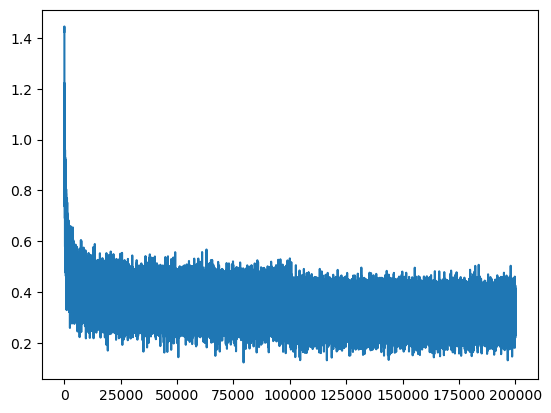

In [10]:
plt.plot(lossi)

In [7]:
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]    # That's a switch (never seen it like this!)
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

    return loss

# split_loss('train')
# split_loss('val')

In [8]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # Forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # Sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # Shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # As soon as we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # Decode and print the generated word

mara.
amyadheeel.
nehayla.
reharsteng.
len.
adeeydeelin.
elynnen.
adennesianar.
kayzinzeka.
caysengergahgenest.
jadeenee.
pantenifiaynennee.
ayidafyela.
kay.
aven.
yae.
helina.
yaysen.
zakeleeunen.
cre.


## Problem 1: Unrealisticly high initial loss

The probability of our model to predict the right and wrong char are same at the start  
Therefore, loss i log(1/27)

In [7]:
## We use negative log likelihood as the loss function
nll = -(torch.log(torch.tensor(1 / 27)))

In [8]:
nll

tensor(3.2958)

The above was the expected loss but ours was much much higher

In [9]:
logits = torch.tensor([[-8.0, 1.0, 4.0, 16.0]])
probs = torch.softmax(logits, dim=0)
loss = F.cross_entropy(logits, torch.tensor([0]))
loss

tensor(24.0000)

The above loss is high because the model don't have any idea that the values are equally likely

In [10]:
probs

tensor([[1., 1., 1., 1.]])

Because the logits are allowed to initially take on such a variety of values, it is unlikely for the NN to quickly learn a good combination of logits that reduces the loss.

We want the logits to be around 0 when we initialize the NN.
Theoretically, the logits could also be chosen around any number.
But, by default, we do this with  0  as the center so that we initialize closely to the range of the normal distribution.

So the question is: How do we get the logits of the output layer to be initially close to  0 ?

Solution: We scale  W2  to be close to  0  and turn off  b2  by setting it to  0 .

In [35]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0 # Initialize to 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [36]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


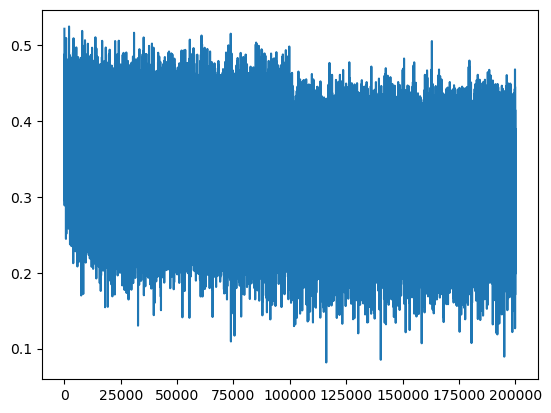

In [37]:
plt.plot(lossi)

Now the loss doesn't have that steep curve there as teh logits are not falsly confident about the results

In [38]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]                            # switch statement
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.1310744285583496


## Problem 2: Tanh Extrema

In [39]:
print(h.shape)
print(h.view(-1).shape)

torch.Size([32, 200])
torch.Size([6400])


tensor([[ 0.7100, -0.7878, -0.7423,  ..., -1.0000,  1.0000,  1.0000],
        [-0.5614, -1.0000, -1.0000,  ..., -0.8078,  0.9971, -0.9209],
        [-1.0000,  0.9940, -1.0000,  ...,  0.3852, -0.9303,  0.3263],
        ...,
        [-0.9992, -1.0000, -0.9999,  ..., -0.4351, -0.8976, -0.3768],
        [ 0.9939,  0.8976,  1.0000,  ..., -0.9538, -1.0000,  0.9987],
        [-1.0000, -0.9995, -1.0000,  ..., -0.6406, -0.8208,  0.5100]],
       grad_fn=<TanhBackward0>) 



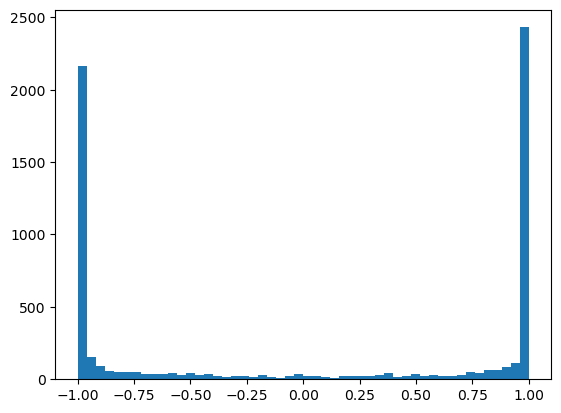

In [40]:
print(h, "\n") # hidden layer activations (32 x 200)
plt.hist(h.view(-1).tolist(), 50); # (6400 x 1), convert tensor to list, show histogram on distribution for 50 bins

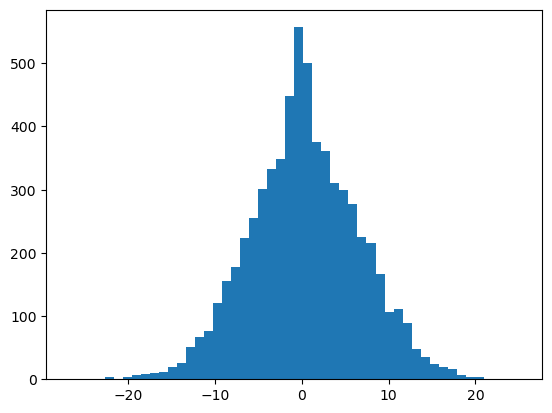

In [41]:
plt.hist(hpreact.view(-1).tolist(), 50);

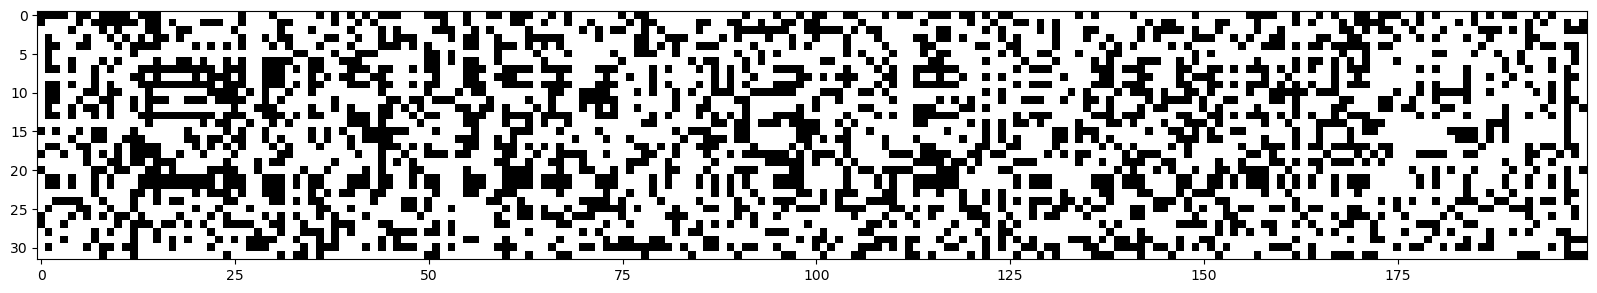

In [42]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In [69]:
## make the ssame changes we did before squash the values of the parameters

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2  ## small but not zero
b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [116]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(42)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1  # Small, but not 0
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # Small, but not 0 bias
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [117]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backwardd pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % (max_steps / 10) == 0:
        print(f"{i}/{max_steps}   {loss.item()}")

    break

0/200000   3.290677070617676


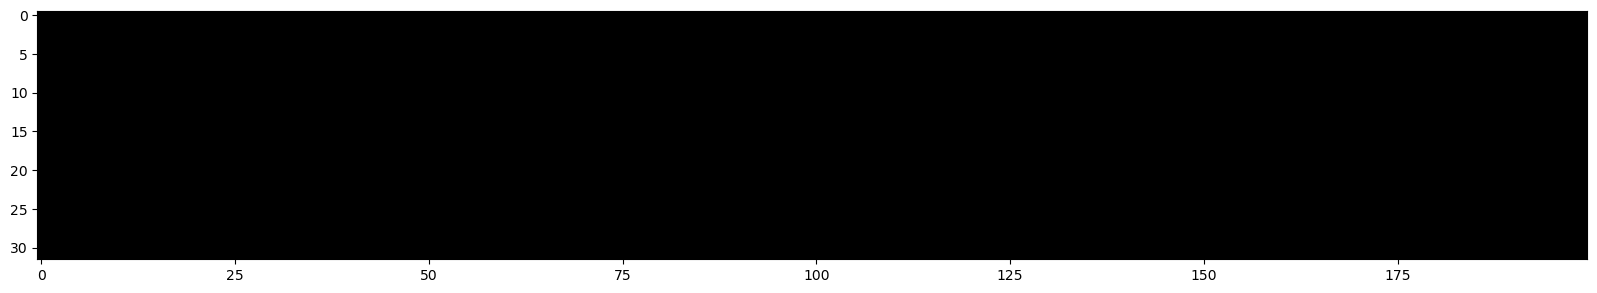

In [118]:
# We actually allow some to reach extremes, but its now rarely the case
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99 , cmap='gray', interpolation='nearest'); # true: white, false: black

tensor([[ 0.4562, -0.9091,  0.0342,  ...,  0.3244, -0.4553,  0.3526],
        [ 0.4986,  0.2121,  0.5500,  ..., -0.0167,  0.3492,  0.6353],
        [ 0.2918,  0.2332, -0.2780,  ...,  0.4783,  0.1764,  0.4186],
        ...,
        [-0.4485,  0.6287, -0.2276,  ..., -0.4807, -0.2322,  0.0969],
        [-0.8102,  0.5325, -0.8173,  ...,  0.4235,  0.2422,  0.3337],
        [ 0.6807,  0.8683, -0.0183,  ..., -0.8619, -0.4508, -0.8861]],
       grad_fn=<TanhBackward0>) 



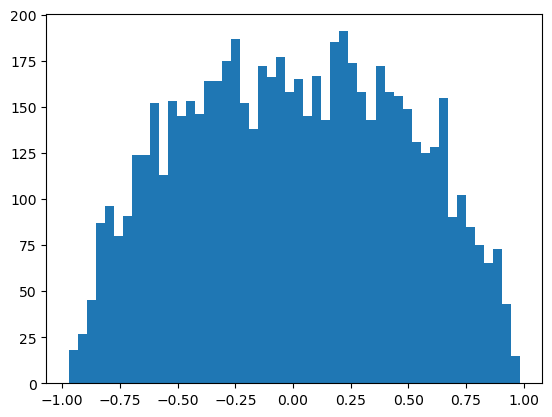

In [119]:
print(h, "\n")
plt.hist(h.view(-1).tolist(), 50);

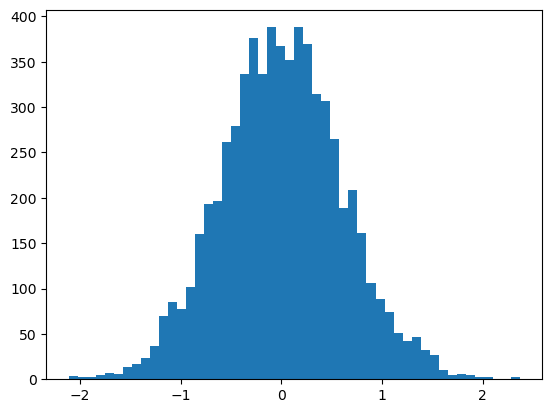

In [120]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [121]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.2757
  10000/ 200000: 1.8681
  20000/ 200000: 1.9424
  30000/ 200000: 2.1672
  40000/ 200000: 2.2394
  50000/ 200000: 2.2379
  60000/ 200000: 2.1330
  70000/ 200000: 2.3479
  80000/ 200000: 2.2356
  90000/ 200000: 2.3857
 100000/ 200000: 2.1209
 110000/ 200000: 1.9910
 120000/ 200000: 2.0612
 130000/ 200000: 2.3894
 140000/ 200000: 1.9982
 150000/ 200000: 2.3133
 160000/ 200000: 2.1461
 170000/ 200000: 2.0426
 180000/ 200000: 1.9470
 190000/ 200000: 2.0885


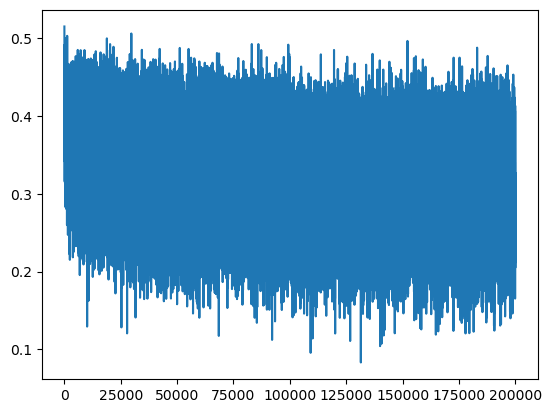

In [122]:
plt.plot(lossi);

In [123]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.05678129196167
val 2.1114611625671387


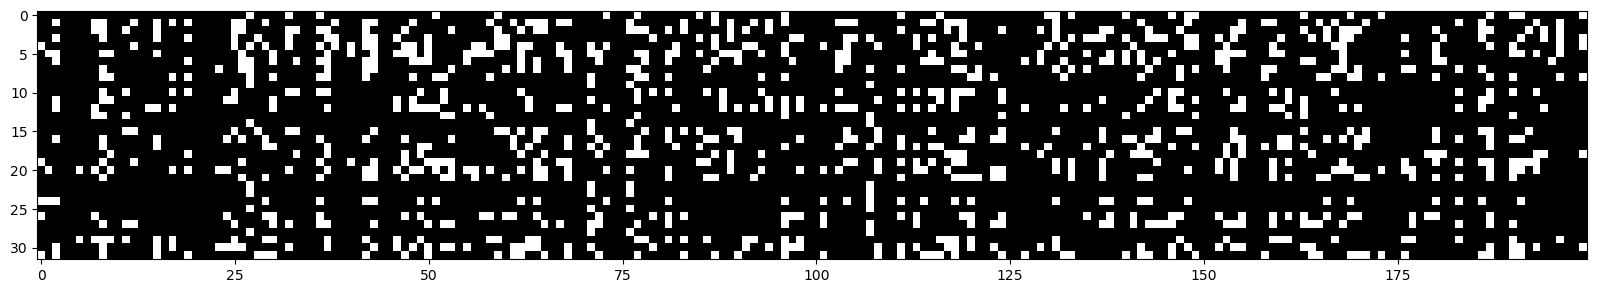

In [124]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest')

## Problem 1 + 2 : Weight + Bias scaling

Well ... we now have a lot of "magic numbers", the factors for the weights and biases:

```
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
```

**How do you determine and set these values for large multilayer MLPs?**

X: tensor(-0.0119) tensor(0.9930)
W: tensor(0.0197) tensor(1.0066)
Y: tensor(0.0107) tensor(3.1597)


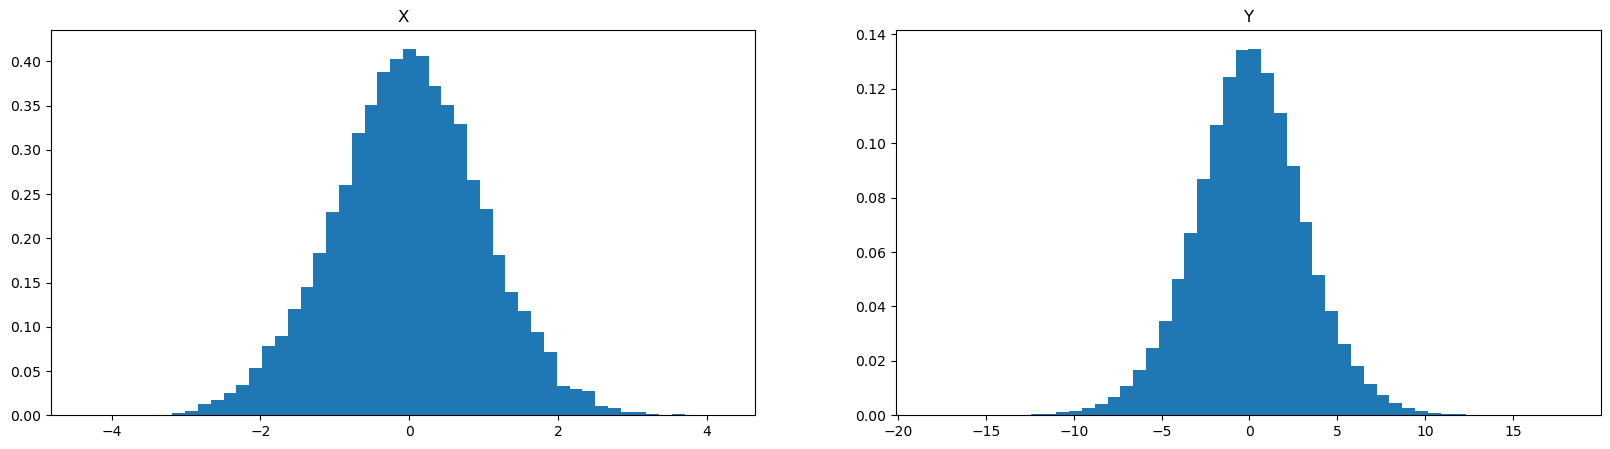

In [125]:
x = torch.randn(1000, 10) # 1000 vectors á 10 dimensions (inputs) (gaussian-distributed)
w = torch.randn(10, 200)  # 10 vectors á 200 dimensions (200 neurons, each looking at 10 inputs)

# [!] We leave out the biases b for this example

y = x @ w # Get the neurons pre-activations

print('X:', x.mean(), x.std())  # mean ~0, standard dev: ~1 (as this is Gaussian)
print('W:', w.mean(), w.std())  # mean ~0, standard dev: ~1 (also Gaussian)
print('Y:', y.mean(), y.std())  # mean ~0, standard dev: ~3 ?!

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('X')
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.title('Y')
plt.hist(y.view(-1).tolist(), 50, density=True);

X: tensor(-4.7463e-05) tensor(0.9972)
W: tensor(-0.0047) tensor(0.3147)
Y: tensor(-0.0017) tensor(0.9948)


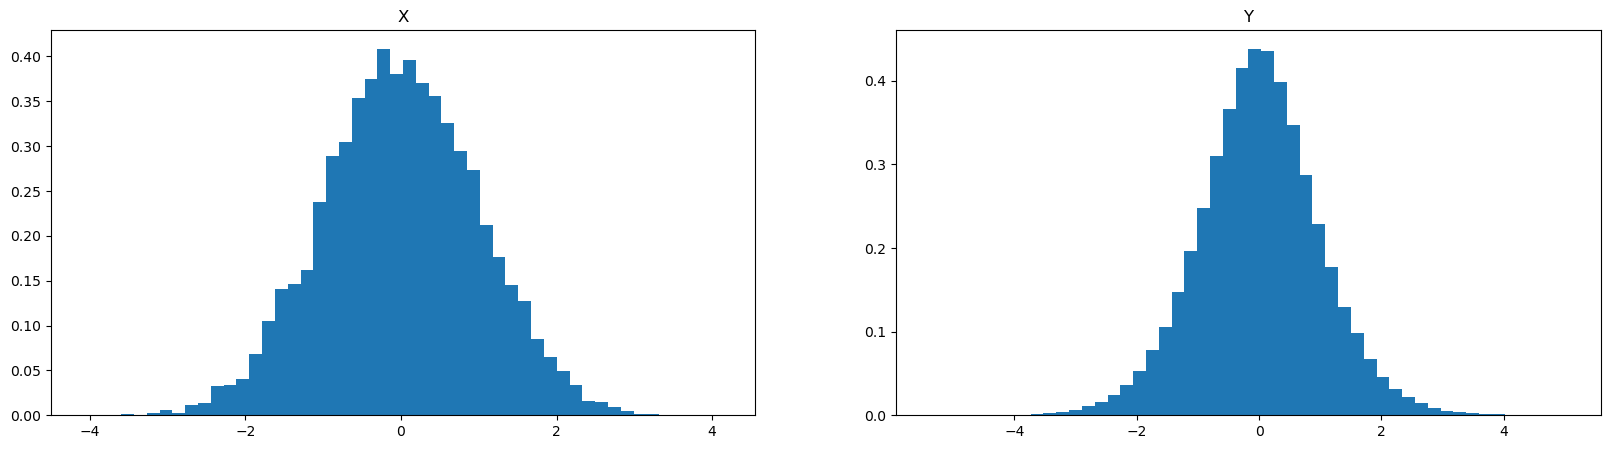

In [126]:
x = torch.randn(1000, 10) 
w = torch.randn(10, 200) * 10**-0.5 # meaning / sqrt(10) or 0.316228

y = x @ w

print('X:', x.mean(), x.std())
print('W:', w.mean(), w.std())
print('Y:', y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('X')
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.title('Y')
plt.hist(y.view(-1).tolist(), 50, density=True);

In [9]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Here (5/3) is gain given for tanh in pytorch
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # the factor makes the std of the output ~1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # Small, but not 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [10]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9751
 190000/ 200000: 1.8614


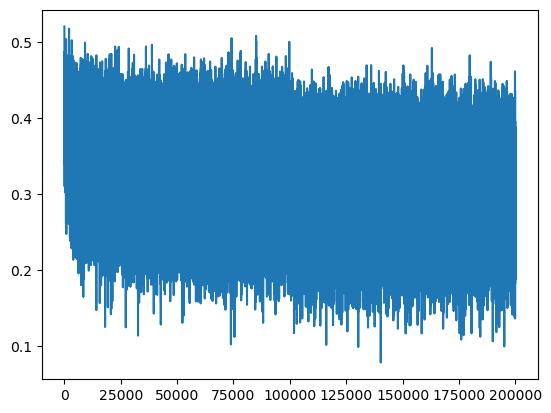

In [11]:
plt.plot(lossi);

In [12]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376646518707275
val 2.1069893836975098


| Losses    | Original  | Solved Problem (1) | Solved Problem (2) | Solved Problem (1+2) |
| --------- | --------- | ------------------ | ------------------ | -------------------- |
| **Train** | 2.1270018 | 2.0695891          | **2.0355966**      | 2.0376642            |
| **Val**   | 2.1699057 | 2.1310747          | **2.1026785**      | 2.1069896            |

We end up roughly where we started. This is actually a good thing, because we no longer have a "magic number" that scales our weights.<br>
We simply calculated the scaling factor we are now using.

To introduce Batch Normalization, first, we calculate the mean along the zero-th dimension (the batch dimension) of `hpreact`:

In [18]:
mean0 = hpreact.mean(0, keepdim=True)

In [19]:
mean0.shape

torch.Size([1, 200])

In [20]:
print('std: ', hpreact.std(0, keepdim=True).shape)

std:  torch.Size([1, 200])


In [26]:
# Normalizing the hpreact

hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True) ** 0.5)

In [27]:
hpreact.shape

torch.Size([32, 200])

In [25]:
hpreact[0, :5]

tensor([ 2.4782,  0.7799, -0.3998, -1.0888,  0.7478], grad_fn=<SliceBackward0>)

In [28]:
hpreact[0, :5]

tensor([ 2.2781,  0.7513, -0.3545, -0.9503,  0.6581], grad_fn=<SliceBackward0>)

In [33]:
## we need to do the above step only once at the start and train the batch norm to learn to optimize

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * ((5/3)/(block_size * n_embd)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12297


In [34]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3149
  10000/ 200000: 2.3311
  20000/ 200000: 2.4343
  30000/ 200000: 2.0402
  40000/ 200000: 2.1428
  50000/ 200000: 1.8935
  60000/ 200000: 2.1852
  70000/ 200000: 2.4852
  80000/ 200000: 2.2232
  90000/ 200000: 1.9615
 100000/ 200000: 2.0917
 110000/ 200000: 2.2161
 120000/ 200000: 1.9413
 130000/ 200000: 2.1396
 140000/ 200000: 1.8985
 150000/ 200000: 2.2107
 160000/ 200000: 2.2587
 170000/ 200000: 1.7979
 180000/ 200000: 2.4788
 190000/ 200000: 2.1109


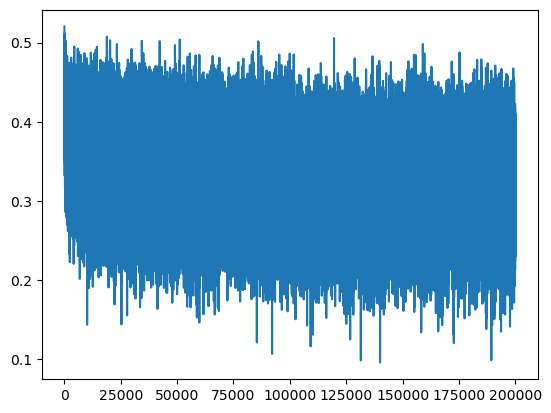

In [35]:
plt.plot(lossi);

In [36]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    # This part is new, just like we did with our new Batch Normalized NN
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    
    h = torch.tanh(hpreact)     # (N, n_hidden)
    logits = h @ W2 + b2        # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.068216562271118
val 2.110870361328125


In [37]:
# New: Calibrate the batch norm at the end of training
with torch.no_grad(): # this makes everything below faster, as "bookkeeping" is turned off
    # pass the (entire) training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set ONCE (cast them into stone)
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [38]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    # This part is new, just like we did with our new Batch Normalized NN
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias # Fix them, hold them, technologic
    
    h = torch.tanh(hpreact)             # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

# Same losses as before
split_loss('train')
split_loss('val')

train 2.068216562271118
val 2.110928773880005


In [40]:
n_embd = 10
n_hidden = 200

# Initializations
g  = torch.Generator().manual_seed(42)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01  ### We don't need you anymore
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

bngain = torch.ones((1, n_hidden))  # 1 x 200, a 1 for each hidden neuron
bnbias = torch.zeros((1, n_hidden)) # 1 x 200, a bias for each hidden neuron

# These two don't require gradient derivation (not added to 'parameters')
bnmean_running = torch.zeros((1, n_hidden)) # hpreact starts as normal. distr. -> mean is 0
bnstd_running = torch.ones((1, n_hidden))   # hpreact starts as normal. distr. -> stddev is 1

parameters = [C, W1, b1, W2, b2, bngain, bnbias] # gain and bias are changed by backprop!!

for p in parameters:
    p.requires_grad = True

In [41]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1
    
    # New: Mean and stddev definitions are outsourced to here
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad(): # This has nothing to do with gradient updating
        # Adding up small updates in the direction of current mean and stddev
        # This will build up to form a total mean and stddev right after training
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3149
  10000/ 200000: 2.3311
  20000/ 200000: 2.4343
  30000/ 200000: 2.0402
  40000/ 200000: 2.1428
  50000/ 200000: 1.8935
  60000/ 200000: 2.1852
  70000/ 200000: 2.4852
  80000/ 200000: 2.2232
  90000/ 200000: 1.9615
 100000/ 200000: 2.0917
 110000/ 200000: 2.2161
 120000/ 200000: 1.9413
 130000/ 200000: 2.1396
 140000/ 200000: 1.8985
 150000/ 200000: 2.2107
 160000/ 200000: 2.2587
 170000/ 200000: 1.7979
 180000/ 200000: 2.4788
 190000/ 200000: 2.1109


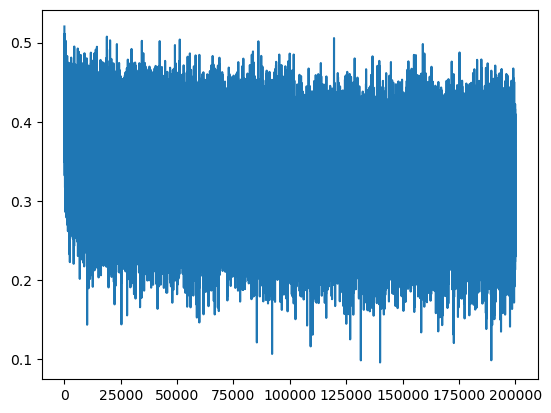

In [42]:
plt.plot(lossi);

In [43]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    # This part is new, just like we did with our new Batch Normalized NN
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    
    h = torch.tanh(hpreact)             # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0680298805236816
val 2.111121892929077


## Now let's start making some respectable things

In [70]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

In [17]:
# Linear Layer Definition (mimicing torch.nn.Linear's structure)
class LinearC:
  
  def __init__(self, fan_in, fan_out, bias=True):
    # Weights with Kaiming just like above would be (W1 * (5/3)/((n_embd * block_size)**0.5))
    # The term (5/3) is still missing, but that's because we don't have a non-linearity here yet
    # We'll add it later
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None # Biases are optional here
  
  def __call__(self, x):
    self.out = x @ self.weight # W*x
    if self.bias is not None:  # Add biases if so desired
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias]) # return layer's tensors

In [31]:
x = torch.linspace(1, 1000, 100).view(10, -1)
lin_out = Linear(10, 1)

In [32]:
lin_out(x)

tensor([[ -3.4207],
        [  8.2713],
        [ 19.9632],
        [ 31.6552],
        [ 43.3472],
        [ 55.0392],
        [ 66.7311],
        [ 78.4231],
        [ 90.1151],
        [101.8071]])

In [33]:
tor_lin = torch.nn.Linear(10, 1)
tor_lin(x)

tensor([[ -51.7041],
        [-143.9465],
        [-236.1889],
        [-328.4313],
        [-420.6737],
        [-512.9161],
        [-605.1586],
        [-697.4010],
        [-789.6434],
        [-881.8859]], grad_fn=<AddmmBackward0>)

In [34]:
linc = LinearC(10, 1)
linc(x)

tensor([[  5.8082],
        [ -2.9246],
        [-11.6575],
        [-20.3903],
        [-29.1231],
        [-37.8559],
        [-46.5887],
        [-55.3216],
        [-64.0543],
        [-72.7871]])

In [69]:
class BatchNorm:
    def __init__(self, dim, eps=1e-5, momentum=0.001):
        self.momentum = momentum
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.eps = eps

        self.running_mean = torch.zeros(dim)
        self.running_std = torch.ones(dim)

    def __call__(self, x):
        mean = x.mean(0, keepdim=True)
        var = x.var(0, keepdim=True)

        xhat = (x - mean) / (var + self.eps) ** 0.5
        self.out = self.gamma * xhat + self.beta

        self.running_mean = self.running_mean * (1 - self.momentum) + mean * self.momentum
        self.running_std = self.running_std * (1 - self.momentum) + var * self.momentum

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [47]:
class BatchNorm1dC:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps            # Epsilon set to PyTorch default, you may change it
    self.momentum = momentum  # Momemtum set to PyTorch default, you may change it
    self.training = True
    # Initialize Parameters (trained with backprop)
    # (bngain -> gamma, bnbias -> beta)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # Initialize Buffers 
    # (Trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  

  def __call__(self, x):
    # Forward-Pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # Batch mean
      xvar = x.var(0, keepdim=True)   # Batch variance
    else:
      xmean = self.running_mean # Using the running mean as basis
      xvar = self.running_var   # Using the running variance as basis
    
    # Normalize to unit variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta  # Apply batch gain and bias
    
    # Update the running buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    
    return self.out
  

  def parameters(self):
    return [self.gamma, self.beta] # return layer's tensors

In [56]:
x = torch.randn((10, 10))

In [57]:
bn = BatchNorm(1)
bn(x)[0]

tensor([-0.3135,  1.5998, -1.4381,  1.1639,  0.0914,  1.4246,  0.5907,  0.4144,
        -0.6105, -0.8551])

In [58]:
bn_tor = torch.nn.BatchNorm1d(10)
bn_tor(x)[0]

tensor([-0.3305,  1.6864, -1.5158,  1.2268,  0.0964,  1.5016,  0.6226,  0.4368,
        -0.6435, -0.9013], grad_fn=<SelectBackward0>)

In [59]:
bnc = BatchNorm1dC(10)
bnc(x)[0]

tensor([-0.3135,  1.5998, -1.4381,  1.1639,  0.0914,  1.4246,  0.5907,  0.4144,
        -0.6105, -0.8551])

In [74]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [76]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].weights *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weights *= 5/3

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

46497


In [77]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        # Stating that non-leaf variable gradients are to be kept/retained for evaluation
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Tracking stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
    break # Take this out to run full optimization/training

      0/ 200000: 3.2848


layer 1 (      Tanh): mean +0.01, std 0.75, saturated: 18.47%
layer 3 (      Tanh): mean -0.03, std 0.68, saturated: 8.97%
layer 5 (      Tanh): mean +0.01, std 0.67, saturated: 6.66%
layer 7 (      Tanh): mean +0.03, std 0.67, saturated: 6.09%
layer 9 (      Tanh): mean -0.05, std 0.65, saturated: 5.47%


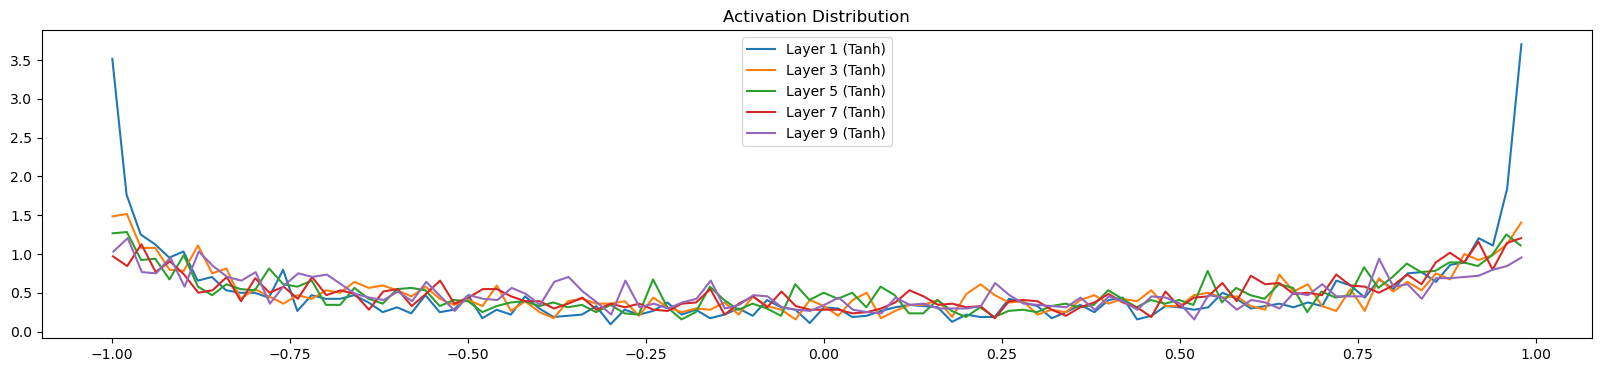

In [78]:
# Visualize histograms (forward pass activations) for the Tanh layers
# (below is what it looks like when Batch-Normalization is needed)
# We can see how many tensor values take on which x-axis values
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer, these are all Tanh layers
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.title('Activation Distribution')
plt.legend(legends);

for gain = 1

In [80]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].weights *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weights *= 1 # Gain of 5/3 replaced by 1

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

46497


In [81]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch-Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y
  
    # Forward-Pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Stack up the layers in orginal order (one after another)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
    # Backward-Pass
    for layer in layers:
        # Stating that non-leaf variable gradients are to be kept/retained for evaluation
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Tracking stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
    break # Take this out to run full optimization/training

      0/ 200000: 3.2959


layer 1 (      Tanh): mean -0.03, std 0.64, saturated: 4.16%
layer 3 (      Tanh): mean +0.02, std 0.48, saturated: 0.12%
layer 5 (      Tanh): mean -0.03, std 0.41, saturated: 0.00%
layer 7 (      Tanh): mean -0.00, std 0.37, saturated: 0.00%
layer 9 (      Tanh): mean -0.02, std 0.32, saturated: 0.00%


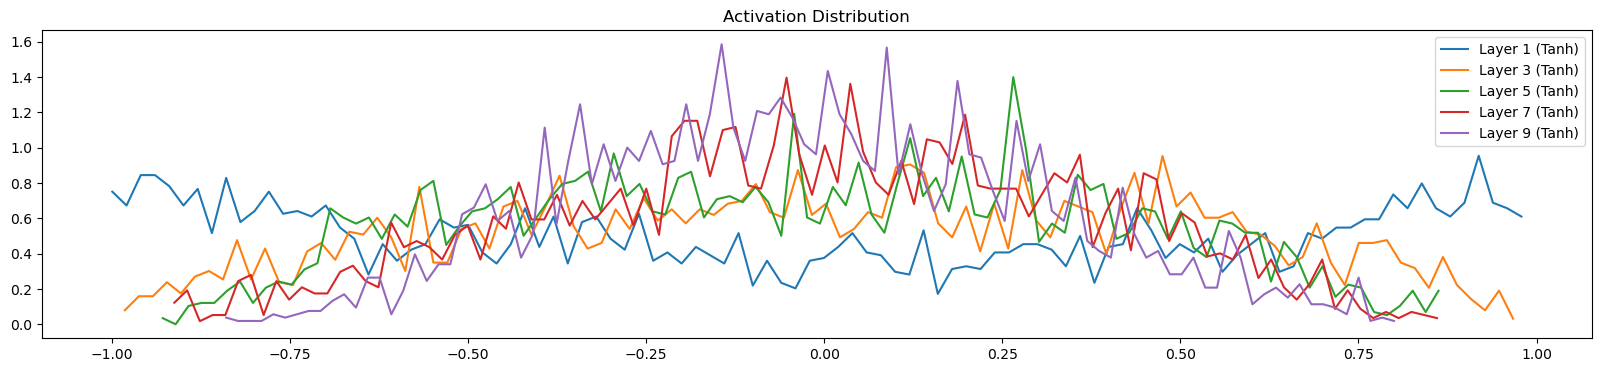

In [82]:
# Visualize activation histogram (i.e. activations) for the Tanh layers
# (below is what a worst-case looks like)
# We can see how many tensor values take on which x-axis values
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.title('Activation Distribution')
plt.legend(legends);

### Gradient Distribution for MLP with Tanh and Correct Gain

In [85]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].weights *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weights *= 5/3

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

46497


In [86]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch-Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y
  
    # Forward-Pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Stack up the layers in orginal order (one after another)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
    # Backward-Pass
    for layer in layers:
        # Stating that non-leaf variable gradients are to be kept/retained for evaluation
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Tracking stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
    break # Take this out to run full optimization/training

      0/ 200000: 3.2985


layer 1 (      Tanh): mean -0.000004, std 3.909893e-04
layer 3 (      Tanh): mean -0.000012, std 3.779023e-04
layer 5 (      Tanh): mean +0.000005, std 3.666596e-04
layer 7 (      Tanh): mean +0.000014, std 3.374091e-04
layer 9 (      Tanh): mean +0.000002, std 3.069165e-04


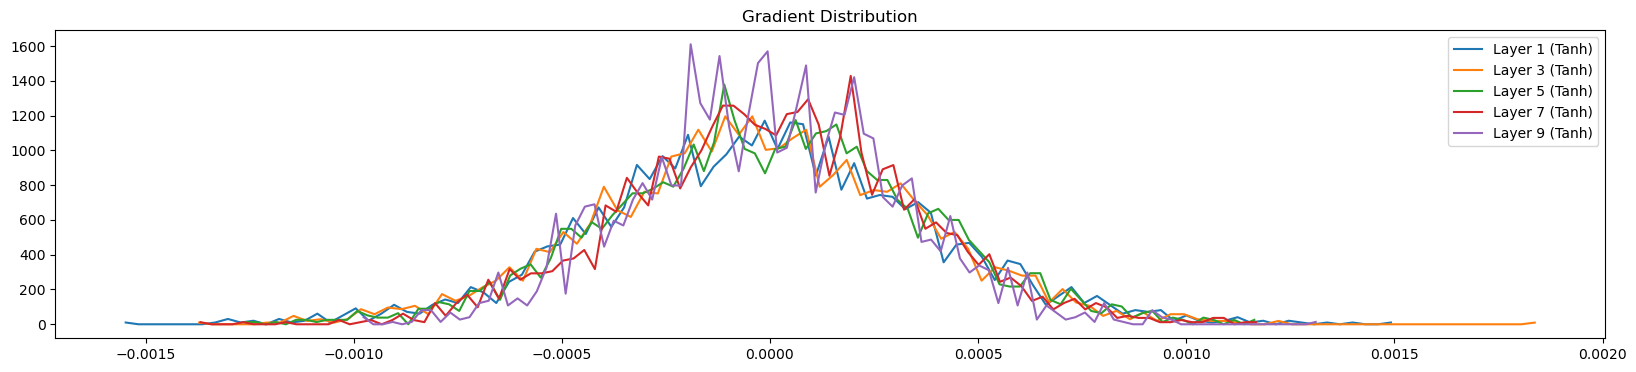

In [89]:
# Visualize Gradient Histogram (below is what it looks like ideally)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.title('Gradient Distribution')
plt.legend(legends);

weight   (27, 10) | mean +0.000099 | std 1.394257e-03 | grad:data ratio 1.393249e-03
weight  (30, 100) | mean +0.000007 | std 1.230551e-03 | grad:data ratio 4.073265e-03
weight (100, 100) | mean -0.000021 | std 9.622934e-04 | grad:data ratio 5.830348e-03
weight (100, 100) | mean -0.000002 | std 9.355439e-04 | grad:data ratio 5.681817e-03
weight (100, 100) | mean -0.000002 | std 8.571608e-04 | grad:data ratio 5.167772e-03
weight (100, 100) | mean -0.000006 | std 7.457694e-04 | grad:data ratio 4.442040e-03
weight  (100, 27) | mean -0.000000 | std 2.285323e-02 | grad:data ratio 2.206412e+00


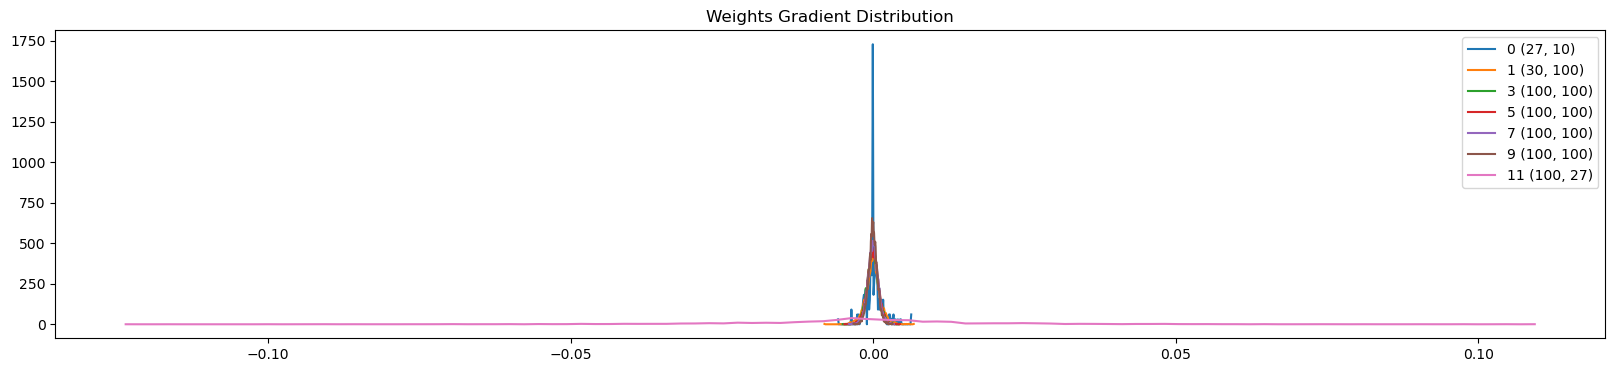

In [88]:
# Visualize histogram of weights of linear Layers (not biases, gammas or betas)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights Gradient Distribution');

In [91]:
# Update to Data Ratio Histogram (below is what it looks like ideally)
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

NameError: name 'ud' is not defined

<Figure size 2000x400 with 0 Axes>

In [94]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1dC(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1dC(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1dC(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1dC(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1dC(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size), BatchNorm1dC(vocab_size), 
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].gamma *= 0.1 # As last layer is a Batch-Normalization
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weights *= 1.0

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

47551


In [95]:
# Same optimization as last time
max_steps = 200000 
batch_size = 32    
lossi = []         # Keeping track of loss
ud = []            # Keeping track of Update-to-Data ratio

for i in range(max_steps):
  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # Forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # Backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # Update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Tracking the stats
  if i % 10000 == 0: # Print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3149


layer 2 (      Tanh): mean +0.01, std 0.62, saturated: 3.81%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 3.22%
layer 8 (      Tanh): mean +0.00, std 0.65, saturated: 2.34%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 2.06%
layer 14 (      Tanh): mean -0.01, std 0.66, saturated: 1.75%


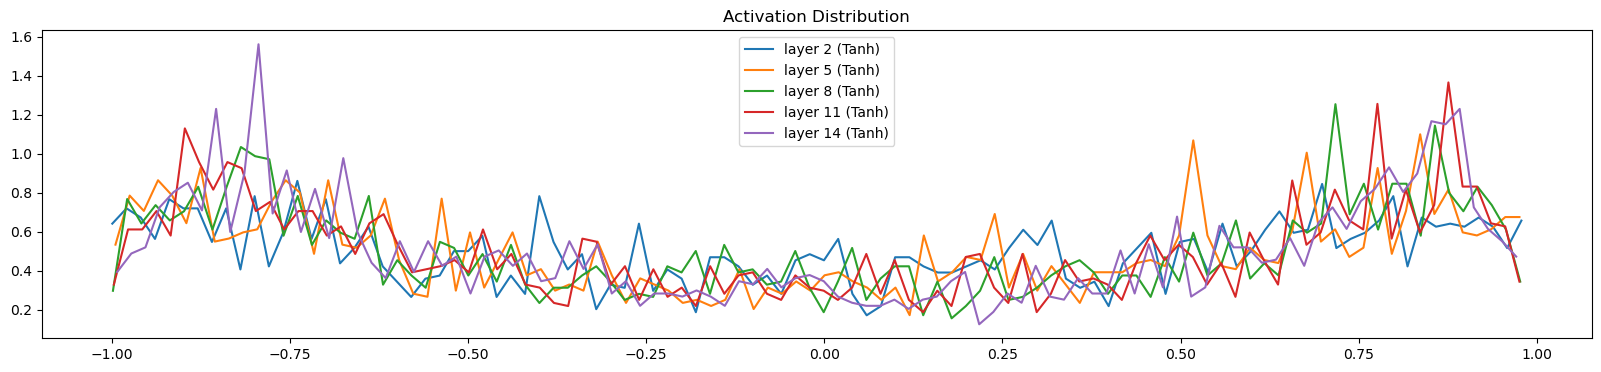

In [96]:
# Visualize histograms (forward pass activations) for the Tanh layers
# This is the ideal graph, very homogeneous
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.title('Activation Distribution')
plt.legend(legends);

layer 2 (      Tanh): mean +0.000000, std 2.589458e-03
layer 5 (      Tanh): mean -0.000000, std 2.160439e-03
layer 8 (      Tanh): mean -0.000000, std 1.986561e-03
layer 11 (      Tanh): mean -0.000000, std 1.898536e-03
layer 14 (      Tanh): mean +0.000000, std 1.895012e-03


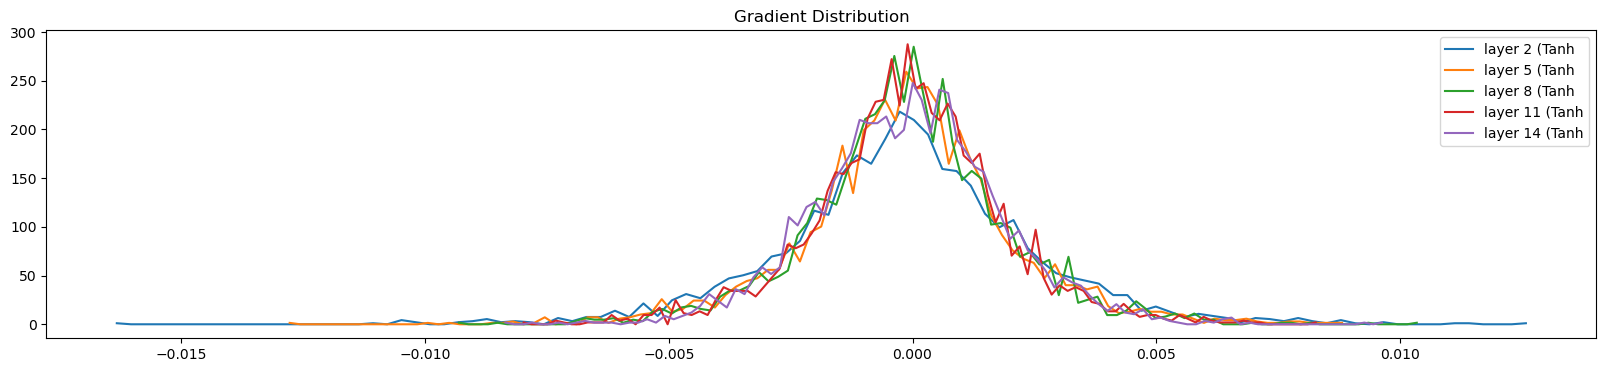

In [97]:
# Visualize Gradient Histogram (this graph looks good)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.title('Gradient Distribution')
plt.legend(legends);

weight   (27, 10) | mean +0.000000 | std 1.080342e-02 | grad:data ratio 1.079243e-02
weight  (30, 100) | mean -0.000009 | std 1.142231e-02 | grad:data ratio 6.108398e-02
weight (100, 100) | mean -0.000098 | std 7.636645e-03 | grad:data ratio 7.446712e-02
weight (100, 100) | mean +0.000159 | std 6.441718e-03 | grad:data ratio 6.348021e-02
weight (100, 100) | mean +0.000078 | std 5.757523e-03 | grad:data ratio 5.651853e-02
weight (100, 100) | mean -0.000005 | std 5.176287e-03 | grad:data ratio 5.100212e-02
weight  (100, 27) | mean +0.000015 | std 9.915668e-03 | grad:data ratio 9.367028e-02


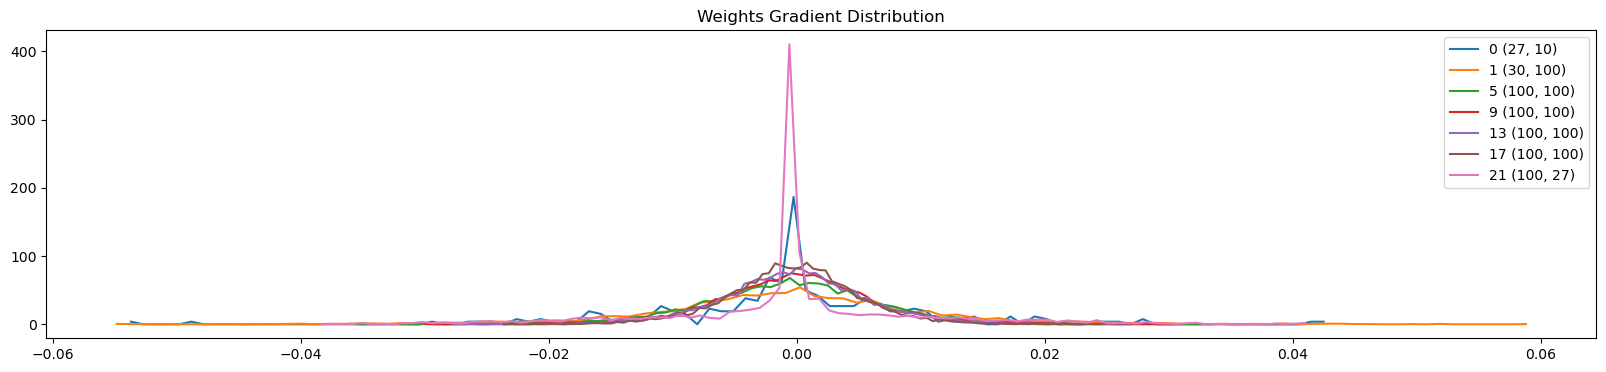

In [98]:
# Visualize histogram of weights of linear Layers (not biases, gammas or betas)
# Ideal graph
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights Gradient Distribution');

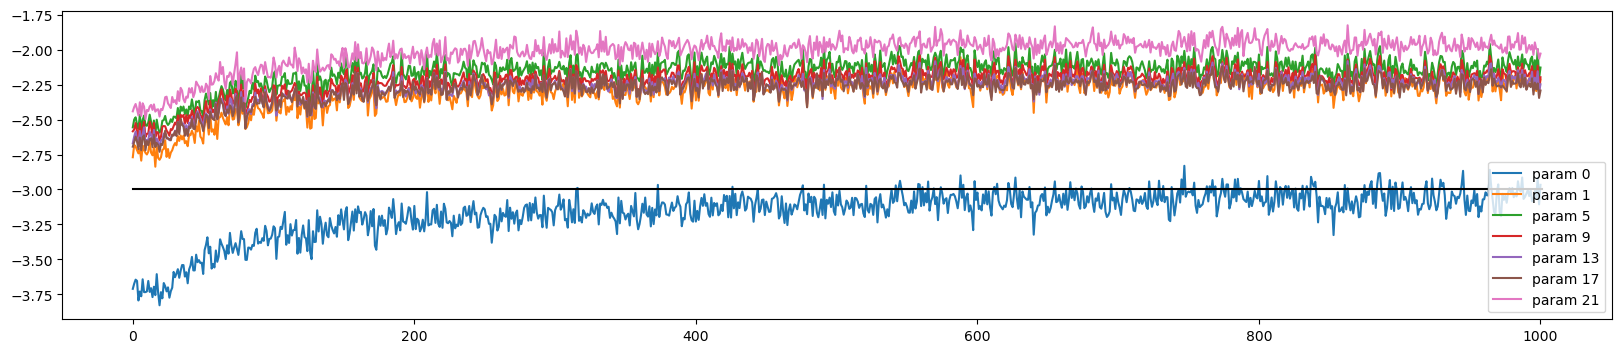

In [99]:
# Update to Data Ratio Histogram (below is what it looks like ideally)
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [100]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import torch

In [102]:
# BatchNorm forward pass as a widget 
# (Run this locally on your machine)

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [103]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853
